# Artist Investigations

Similar to the playlist investigations

In [48]:
artist_name = "Freddie Gibbs"
artist_frame = scrobbles.query(f'artist == "{artist_name}"') # FILTER SCROBBLES
artist_frame = artist_frame.sort_index(ascending=False) # SORT
# artist_frame = artist_frame.loc[:, descriptor_headers] # DESCRIPTORS

total_time = artist_frame["duration_ms"].sum() / (1000 * 60) # minutes
total_days = total_time / (60 * 24) # days
print(f'{artist_frame.count()[0]:,d} scrobbles')
print(f'{total_days:.0f} days spent listening since Nov. 2017')
print(f'{total_time / days_since(first_day).days:.2f} minutes/day')

artist_frame.describe()[1:]

2,220 scrobbles
5 days spent listening since Nov. 2017
6.43 minutes/day


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
mean,0.212988,0.556427,206109.940541,0.689568,0.038141,5.493694,0.328512,-8.165929,0.677928,0.297323,110.274670,3.997297,0.507103
std,0.195843,0.145240,62979.977621,0.132678,0.159018,3.646806,0.184782,1.846141,0.467376,0.127891,32.589491,0.150085,0.194317
min,0.000843,0.256000,48507.000000,0.176000,0.000000,0.000000,0.052900,-16.918000,0.000000,0.029600,56.046000,3.000000,0.038300
25%,0.049700,0.450000,168009.000000,0.604000,0.000000,1.000000,0.161000,-9.363000,0.000000,0.203000,88.607000,4.000000,0.373000
50%,0.161000,0.528000,201158.000000,0.668000,0.000002,6.000000,0.325000,-8.336000,1.000000,0.299000,91.973000,4.000000,0.504000
75%,0.261000,0.604000,226520.000000,0.805000,0.000648,8.000000,0.464000,-6.832000,1.000000,0.380000,130.396000,4.000000,0.631000
max,0.946000,0.948000,513707.000000,0.946000,0.901000,11.000000,0.796000,-2.002000,1.000000,0.749000,188.050000,5.000000,0.959000


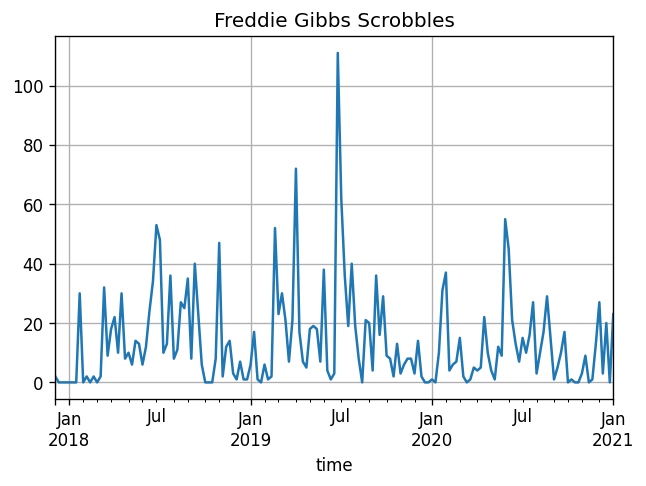

In [52]:
filtered_artist = scrobbles.query(f'artist == "{artist_name}"')
# resample by day and mean
filtered_artist = filtered_artist.resample("1W").count()

filtered_artist["energy"].plot()

plt.title(f"{artist_name} Scrobbles")
plt.grid()
plt.show()

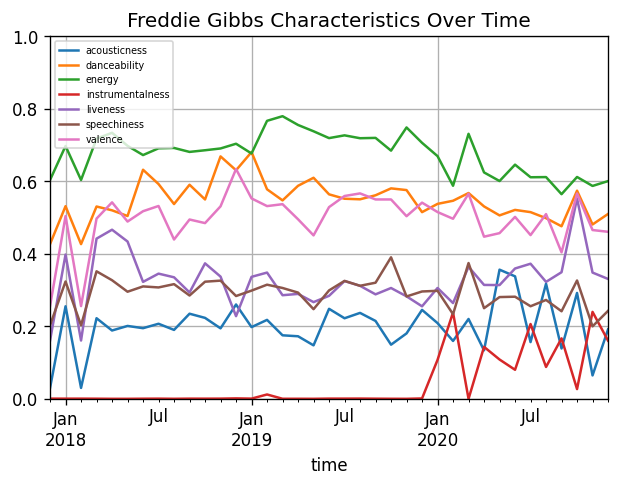

In [51]:
filtered_artist = scrobbles.query(f'artist == "{artist_name}"')
# select only descriptor float columns
filtered_artist = filtered_artist.loc[:, float_headers]
# resample by day and mean
filtered_artist = filtered_artist.resample("1M").mean()

# filtered_playlist["energy"].plot()
filtered_artist.plot()

plt.title(f"{artist_name} Characteristics Over Time")
plt.legend(loc = "upper left", fontsize = "xx-small")
plt.ylim([0, 1])
plt.grid()
plt.show()

# Artist Listening Time

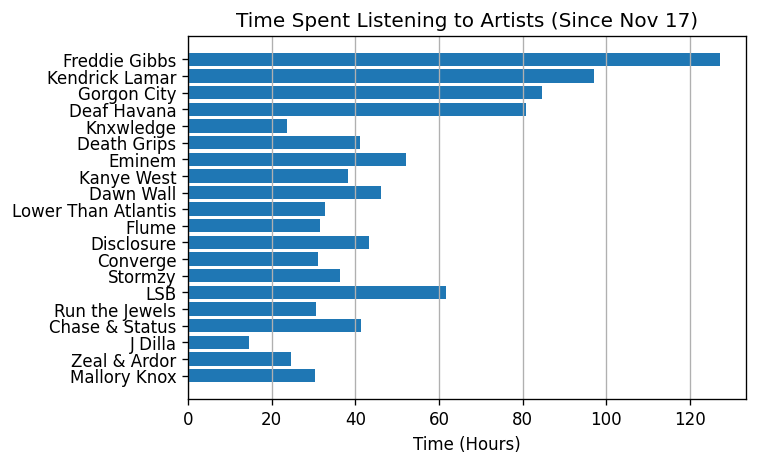

In [13]:
artists = fmnet.top_artists(period=fmnet.Range.OVERALL, limit=20)

filtered_artists = [scrobbles.query(f'artist == "{i}"') for i in artists]
artists_time = [i["duration_ms"].sum() for i in filtered_artists]

plt.barh(np.arange(len(artists))[::-1], np.array(artists_time) / (1000 * 60 * 60) )
plt.yticks(np.arange(len(artists))[::-1], labels=[i.name for i in artists])
plt.xlabel("Time (Hours)")
plt.grid(axis="x")
plt.title("Time Spent Listening to Artists (Since Nov 17)")
plt.show()

# Imports & Setup

In [6]:
from datetime import datetime

from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

from analysis.net import get_spotnet, get_fmnet, get_playlist, track_frame
from analysis.query import *
from analysis import descriptor_headers, float_headers, days_since

import pandas as pd
import numpy as np

client = bigquery.Client()
spotnet = get_spotnet()
fmnet = get_fmnet()
cache = 'query.csv'
first_day = datetime(year=2017, month=11, day=3)

## Read Scrobble Frame

In [4]:
scrobbles = get_query()

## Write Scrobble Frame

In [ ]:
scrobbles.to_csv(cache, sep='\t')